In [1]:
from safetensors.torch import load_model, save_model, load_file
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoConfig, AutoModelForCausalLM,AutoTokenizer,BitsAndBytesConfig,AutoModel,TrainingArguments, Trainer,DataCollatorWithPadding, EarlyStoppingCallback, get_constant_schedule_with_warmup
import transformers
from datasets import load_dataset, Dataset, load_from_disk
from stripedhyena.tokenizer import CharLevelTokenizer
from stripedhyena.model import StripedHyena
from stripedhyena.layers import VocabParallelEmbedding
from stripedhyena.utils import dotdict
import yaml
import multiprocessing
from tqdm import tqdm
from accelerate import Accelerator, DistributedType
from torch.utils.data import DataLoader
import os


In [2]:
data_files = './processed_data'
cpu_cnt = multiprocessing.cpu_count()
max_length = 300
model_name = './evo-1-8k-base'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


print(torch.version.cuda)

Using device: cuda

NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
11.8


/home/ubuntu/thermo-evo/miniconda3/envs/thermo-evo/lib/python3.10/site-packages/torch/cuda/memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,padding='max_length',bos_token='\x00')
tokenizer.pad_token = '\x01'
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,max_length=max_length,padding='max_length')
#Evo utilizes a custom tokenizer named "CharLevelTokenizer", huggingface version does not have pad_token defined. Thus pad_token is manually defined to have same value as the pad_token utilizes in CharLevelTokenizer

def prefix_function(d):
    d['dna_seq'] = tokenizer.bos_token + d['dna_seq']
    return d

def tokenize_function(d):
    return tokenizer(d['dna_seq'], padding='max_length',max_length = max_length)

In [5]:
def prepare_dsets(data_path,batch_size):
    dsets = load_from_disk(data_path)
    #dsets = dsets.map(prefix_function, num_proc=cpu_cnt)
    dsets = dsets.map(tokenize_function, batched=True, num_proc=cpu_cnt)
    useful_col = ['input_ids', 'attention_mask', 'labels']
    dsets = dsets.remove_columns([col for col in dsets['train'].column_names if col not in useful_col])
    train_loader = DataLoader(
        dsets['train'],
        collate_fn=data_collator,
        shuffle=True,
        batch_size=batch_size
        )
    val_loader = DataLoader(
            dsets['val'],
            collate_fn=data_collator,
            shuffle=True,
            batch_size=batch_size
        )
    test_loader = DataLoader(
            dsets['test'],
            collate_fn=data_collator,
            shuffle=True,
            batch_size=batch_size
        )
    return train_loader,val_loader,test_loader, len(dsets['test'])


In [6]:
model_config = AutoConfig.from_pretrained(model_name,trust_remote_code=True)
model_config.use_cache = False
model_og = AutoModelForCausalLM.from_pretrained(
    model_name,
    config=model_config,
    trust_remote_code=True,
)

config_path = './custom_config.yaml'
#state_dict = model_og.backbone.state_dict()
config = yaml.safe_load(open(config_path, 'rb').read())
global_config = dotdict(config, Loader=yaml.FullLoader)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
class MyHyena(StripedHyena):
    def __init_(self,config):
        super().__init__()
        self.config = config
        self.embedding_layer = VocabParallelEmbedding(config)
        self.norm = RMSNorm(config) if config.get("final_norm", True) else None
        #self.unembed = self.embedding_layer if config.tie_embeddings else VocabParallelEmbedding(config)

        if config.get("use_flashfft", "True"):
            try:
                from flashfftconv import FlashFFTConv

                self.flash_fft = FlashFFTConv(config.seqlen, dtype=torch.bfloat16)
            except ImportError:
                "flashfftconv not installed"
        else:
            self.flash_fft = None

        self.blocks = nn.ModuleList(
            get_block(config, layer_idx, flash_fft=self.flash_fft) for layer_idx in range(config.num_layers)
        )

    def forward(self, x, inference_params_dict=None, padding_mask=None):
        L = x.shape[1]
        x = self.embedding_layer.embed(x)
        if inference_params_dict is not None:
            x, inference_params_dict_out = self.stateful_forward(
                x,
                inference_params_dict=inference_params_dict,
            )
        else:
            x, inference_params_dict_out = self.stateless_forward(x, padding_mask=padding_mask)

        x = self.norm(x)
        #Removed unembedding
        #x = self.unembed.unembed(x)
        return x, inference_params_dict_out

In [8]:
custom_hyena = MyHyena(global_config)

In [9]:
class EvoForRegression(nn.Module):
  def __init__(self): 
    super(EvoForRegression,self).__init__() 

    self.model = custom_hyena
    self.dropout = nn.Dropout(0.1) 
    #First_Token representation

    self.lin = nn.Linear(model_config.hidden_size,model_config.hidden_size) 
    self.out = nn.Linear(model_config.hidden_size,1) 
      

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the hyena
    outputs = self.model(x=input_ids, padding_mask=attention_mask)[0][:,0,:]
    #Add custom layers
    outputs = self.lin(outputs)    
    outputs = nn.ReLU()(outputs)  
    out = self.out(outputs)

    return out

In [10]:
train_loader,val_loader,test_loader, test_steps = prepare_dsets(data_files,512)

Map (num_proc=30):   0%|          | 0/540232 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/115765 [00:00<?, ? examples/s]

Map (num_proc=30):   0%|          | 0/115764 [00:00<?, ? examples/s]

In [11]:
def eval_model(model,OUT_DIR,batch_size,warmup_steps = 10,checkpointing_steps=1000):
    os.makedirs(OUT_DIR, exist_ok=True)
    
    train_loader,val_loader,test_loader, epoch_size = prepare_dsets(data_files,batch_size)
    
    accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="bf16"
    )
    
    accelerator.print(f"Total GPUS: {accelerator.num_processes}")
    
    
    num_training_steps = epoch_size // batch_size
    num_epoch_steps = num_training_steps // 1

                                         
    model,test_loader= accelerator.prepare(model, test_loader)
    

    
    progress_bar = tqdm(range(num_training_steps))
    completed_steps = 0
    

    loss_fn = torch.nn.MSELoss()


    
    log_loss = os.path.join(OUT_DIR,'test_log')
    loss_file = open(log_loss, "w", encoding="utf-8") if accelerator.is_main_process else None
    #loss_file = open(log_loss, "a" if resume_from_checkpoint else "w", encoding="utf-8") if accelerator.is_main_process else None
    model.eval()
    pred_outputs = []
    for step, batch in enumerate(test_loader):
            loss_log = None
            with torch.no_grad():
                outputs = model(**batch)
                gathered = (outputs.squeeze(),batch['labels'].squeeze())
                loss = loss_fn(outputs.squeeze(),batch['labels'].squeeze())
                pred_outputs.append(gathered)
                if accelerator.sync_gradients:
                    loss_log = {
                        "loss": loss.item(),
                        "epoch": completed_steps / num_epoch_steps
                    }
                    accelerator.log(loss_log, step=completed_steps)
                    if loss_file is not None:
                        loss_file.write(f"{loss_log['loss']},")
                        loss_file.flush()
    
            if accelerator.sync_gradients:
                progress_bar.update(1)
                if loss_log is not None:
                    progress_bar.set_postfix(loss_log)
                completed_steps += 1
                
    
                if completed_steps > 0:
                    if completed_steps % checkpointing_steps == 0:
                        output_dir = f"step_{completed_steps}"
                        if OUT_DIR is not None:
                            output_dir = os.path.join(
                                OUT_DIR, output_dir)
                        accelerator.save_state(output_dir)

        
            if completed_steps >= num_training_steps:
                print(completed_steps)
                print(num_training_steps)
                print('broke')
                break
    return pred_outputs

In [12]:

model = EvoForRegression()
path_to_tst = './loop/64/final.pickle'
model.load_state_dict(torch.load(path_to_tst))
OUT_DIR =  './loop/64/test_outs'
test_out = eval_model(model,OUT_DIR,128)


Total GPUS: 1


100%|██████████| 904/904 [57:00<00:00,  3.78s/it, loss=3.08, epoch=0.999]  

904
904
broke


In [13]:
from sklearn.metrics import r2_score, mean_squared_error
output_vals = []
target_vals = []
for output_val, target_val  in test_out:
    output_val = output_val.cpu()
    target_val = target_val.cpu()
    output_vals.extend(output_val)
    target_vals.extend(target_val)
mean_squared_error(target_vals,output_vals)

2.8167474

In [14]:
r2_score(target_vals,output_vals)

-0.0006664263661311232

Text(0.5, 1.0, 'Training Loss for model 1')

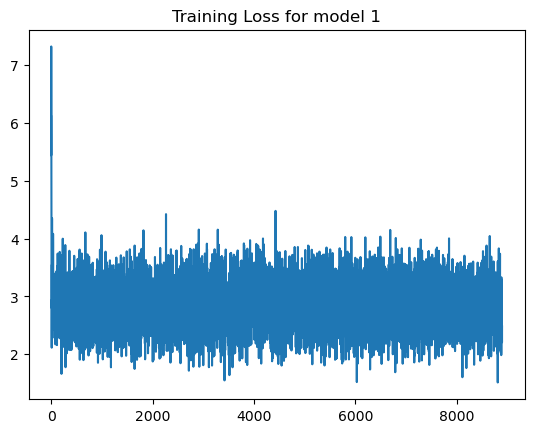

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
training_logs = pd.read_csv('./loop/64/train_log',sep=',', header=None)
plt.plot(training_logs.values[0])
plt.title("Training Loss for model 1") 

In [19]:
np.mean(training_logs.values[0][:-1])

2.82534992004738